In [87]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [88]:
from helpers import load_data, preprocess_data

path_dataset = "movielens100k.csv"
ratings = load_data(path_dataset)

number of items: 1682, number of users: 943


### Plot the number of ratings per movie and user

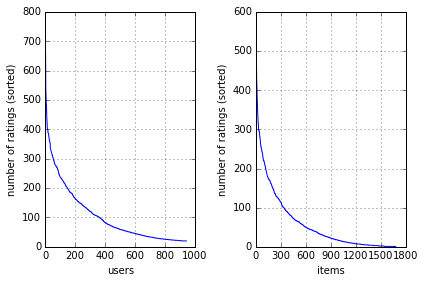

min # of items per user = 20, min # of users per item = 1.


In [89]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [90]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    
    num_items, num_users = valid_ratings.shape 
    
    # create indices
    index_split = int(np.floor((1 - p_test) * num_items))
    indices = np.random.permutation(num_items)
    index_tr = indices[: index_split]
    index_te = indices[index_split:]
    
    # create split
    
    train = valid_ratings[index_tr]
    test = valid_ratings[index_te] 
        
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

Total number of nonzero elements in origial data:99999
Total number of nonzero elements in train data:88654
Total number of nonzero elements in test data:9298


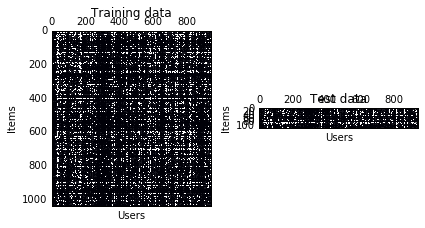

In [91]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

## Implementing Baselines 

In [92]:
 def calculate_rmse(x, prediction):
    
    indices = x.nonzero()
    nonzero_x = x[indices[0], indices[1]]
    nonzero_prediction = prediction[indices[0], indices[1]]
    
    return np.sqrt(calculate_mse(nonzero_x, nonzero_prediction).sum() / (2 * x.nnz))
    

### Use the global mean to do the prediction

In [93]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    
    # initialization
    num_items_train, num_users = train.shape 
    train_prediction = np.ones(shape=(num_items_train, num_users))
    num_items_test, num_users = test.shape 
    test_prediction = np.ones(shape=(num_items_test, num_users))
    
    # mean of whole matrix
    mean_train = train.sum() / train.nnz   
    mean_test = test.sum() / test.nnz   
    
    # filling table
    train_prediction = train_prediction * mean_train
    test_prediction = test_prediction * mean_test
    
    # rmse 
    train_rmse = calculate_rmse(train, train_prediction)
    test_rmse = calculate_rmse(test, test_prediction)
    
    print("Global mean prediction test rmse: {te} and train rmse {tr}".format(te = test_rmse, tr = train_rmse))

baseline_global_mean(train, test)

Global mean prediction test rmse: 0.7936154282034351 and train rmse 0.7886708123850139


### Use the user means as the prediction

In [94]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    
    # initialization
    num_items_train, num_users = train.shape
    num_items_test, num_users = test.shape
    train_prediction = np.ones(shape=(num_items_train, num_users))
    test_prediction = np.ones(shape=(num_items_test, num_users))
    
    # mean of for each user
    sums_train = train.sum(axis=0)
    counts_train = np.diff(train.tocsc().indptr) # counts number of non zero value for each col
    mean_train_user = sums_train / counts_train    
    
    sums_test = test.sum(axis=0)
    counts_test = np.diff(test.tocsc().indptr) # counts number of non zero value for each col
    mean_test_user = sums_test / counts_test
            
    # constructs prediction matrix    
    for x in range(0, num_items_train):
        train_prediction[x] = mean_train_user
        
    for x in range(0, num_items_test):
        test_prediction[x] = mean_test_user
    
    train_rmse = calculate_rmse(train, train_prediction)
    test_rmse = calculate_rmse(test, test_prediction)
    
    print("User mean prediction test rmse: {te} and train rmse {tr}".format(te = test_rmse, tr = train_rmse))
    
baseline_user_mean(train, test)

User mean prediction test rmse: 0.6944697426175084 and train rmse 0.726437209302401


/home/chris/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide


### Use the item means as the prediction

In [95]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""

    # initialization
    num_items_train, num_users = train.shape
    num_items_test, num_users = test.shape
    train_prediction = np.ones(shape=(num_items_train, num_users))
    test_prediction = np.ones(shape=(num_items_test, num_users))
    
    # mean of for each item
    sums_train = train.sum(axis=1).reshape(num_items_train,)
    counts_train = np.diff(train.tocsr().indptr) # counts number of non zero value for each row
    mean_train_item = sums_train / counts_train    
    
    sums_test = test.sum(axis=1).reshape(num_items_test,)
    counts_test = np.diff(test.tocsr().indptr) # counts number of non zero value for each row
    mean_test_item = sums_test / counts_test
            
    # constructs prediction matrix    
    for x in range(0, num_users):
        train_prediction[:,x] = mean_train_item
        test_prediction[:,x] = mean_test_item
    
    train_rmse = calculate_rmse(train, train_prediction)
    test_rmse = calculate_rmse(test, test_prediction)
    
    print("Item mean prediction test rmse: {te} and train rmse {tr}".format(te = test_rmse, tr = train_rmse))
    
baseline_global_mean(train, test)  
baseline_user_mean(train, test)
baseline_item_mean(train, test)

Global mean prediction test rmse: 0.7936154282034351 and train rmse 0.7886708123850139
User mean prediction test rmse: 0.6944697426175084 and train rmse 0.726437209302401


/home/chris/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide


Item mean prediction test rmse: 0.7172612016452605 and train rmse 0.7057576370630403


### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [96]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
        
    # initalization
    num_items, num_users = train.shape
    item_features = np.random.rand(num_features, num_items)
    user_features = np.ones(shape = (num_features, num_users))
    
    # mean of for each item
    sums_train = train.sum(axis=1).reshape(num_items,)
    counts_train = np.diff(train.tocsr().indptr) # counts number of non zero value for each row
    mean_train_item = sums_train / counts_train
    
    item_features[0,:] = mean_train_item;
    
    
    return user_features, item_features 

Compute the cost by the method of matrix factorization.


In [119]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""

    # initalization
    prediction = (item_features.T).dot(user_features)
    x, y = zip(*nz)
    
    # remove zero elements
    prediction_nz = prediction[x,y]
    data_nz = data[x,y]
        
    # rmse    
    return np.sqrt(calculate_mse(data_nz, prediction_nz).sum() / (data.nnz))

In [120]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 5     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
        
            e_dn = train[d,n] - (item_features[:,d].T).dot(user_features[:,n])
            grad_user = e_dn * item_features[:, d] - lambda_user * user_features[:, n]
            grad_item =  (e_dn * user_features[:, n] - lambda_item * item_features[:, d])
            
            item_features[:, d] = item_features[:, d] + gamma * grad_item
            user_features[:, n] = user_features[:, n] + gamma * grad_user           
                
                
        regularized_term = lambda_user / 2 * np.linalg.norm(user_features) + lambda_item / 2 * np.linalg.norm(item_features)    
        rmse = compute_error(train, user_features, item_features, nz_train) 

        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)
    
    
    print("TEST")

    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))   

matrix_factorization_SGD(train, test)   

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.0201015167221694.
iter: 1, RMSE on training set: 0.9854880512784944.
iter: 2, RMSE on training set: 0.9713966294281696.
iter: 3, RMSE on training set: 0.9616738161511146.
iter: 4, RMSE on training set: 0.9593154248876922.
TEST
RMSE on test data: 1.2756019492581858.


### Learn the Matrix Factorization using Alternating Least Squares

In [114]:
def calculate_rmse_als(train, item_features, user_features, indices_nz):
    nz_nb = np.count_nonzero(indices_nz)
    prediction = (item_features.T).dot(user_features)
    print(prediction[prediction > 0])
    mse = np.multiply(indices_nz, train - prediction)
    rmse = np.sum(mse.dot(mse.T))/(2 * nz_nb)
    
    return np.sqrt(rmse)

In [117]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    
    I = np.eye(item_features.shape[0])
    
    Ai = item_features.dot(np.diag(nz_user_itemindices).dot(item_features.T)) #+ lambda_user * I * nnz_items_per_user
    Vi = item_features.dot(np.diag(nz_user_itemindices).dot(train.toarray()))

    updated_user_features = np.linalg.solve(Ai,Vi)
        
    return updated_user_features.reshape(item_features.shape[0],)
    

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    
    I = np.eye(user_features.shape[0])
    
    Ai = user_features.dot(np.diag(nz_item_userindices).dot(user_features.T)) #+ lambda_item * I * nnz_users_per_item
    Vi = user_features.dot(np.diag(nz_item_userindices).dot(train.toarray().T))
    
    updated_item_features = np.linalg.solve(Ai,Vi)
    
    return updated_item_features.reshape(user_features.shape[0],)
    

In [118]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    error_list[0] = 1000
    
    # init matrix with 0 if not rated and 1 if rated
    indices_nz = train.copy().toarray()
    indices_nz[indices_nz > 0] = 1
        
    while (abs(error_list[0] - error_list[1]) > stop_criterion):
                
        # Fix W (item), estimate Z (user)
        for i, nz_user_itemindices in enumerate(indices_nz.T):
            nnz_items_per_user = np.count_nonzero(nz_user_itemindices)
            user_features[:,i] = update_user_feature(train[:,i], item_features, lambda_user, nnz_items_per_user, nz_user_itemindices)
        
        # Fix Z, estimate W
        for j, nz_item_userindices in enumerate(indices_nz):
            nnz_users_per_item = np.count_nonzero(nz_item_userindices)
            item_features[:,j] = update_item_feature(train[i], user_features, lambda_item, nnz_users_per_item, nz_item_userindices)
        
        error_list[change] = calculate_rmse_als(train, item_features, user_features, indices_nz)
    
        print("RMSE on train data: {}.".format(error_list[change]))
    
        if(change == 1):
            change = 0
        else:
            change = 1
        
    print("Converged")

ALS(train, test)

[ 0.04867983  0.04502036  0.03018863 ...,  0.06348872  0.64526642
  9.49288775]
RMSE on train data: 32.30961677423029.


KeyboardInterrupt: 